# Import packages

In [1]:
import os, wget, zipfile
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

# Download and extract data

In [2]:
def download_data(destination_dir, url="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6960825/bin/sensors-19-05524-s001.zip"):

    # Make path if does not exits
    if(os.path.exists(destination_dir) == False):
        os.makedirs(destination_dir)
    # Download data if it does not exist on disk
    if(os.path.exists(os.path.join(destination_dir, "sensors-19-05524-s001.zip")) == False):
        wget.download(url, destination_dir)
        
def extract_data(data_dir, filename="sensors-19-05524-s001.zip"):
    
    with zipfile.ZipFile(os.path.join(data_dir, filename), 'r') as zip_ref:
        zip_ref.extractall(data_dir)

In [3]:
# Specify project root directory
root_dir = "/mnt/Disk-2/My Stuff/UWaterloo/Coursework/Spring'22/ECE 659/Project/activity-recognition/"
# Specify data directory
raw_data_dir = os.path.join(root_dir, 'data/raw')
# Download data
download_data(raw_data_dir)
# Extract data
extract_data(raw_data_dir)

# Load data

In [4]:
# Load data
data_path = os.path.join(raw_data_dir, 'data.txt')
data = pd.read_csv(data_path, header=None)

# Load column headers
column_headers_path = os.path.join(raw_data_dir, 'labels.txt')
column_headers = np.loadtxt(column_headers_path, delimiter='\n', dtype='str')

# Insert column headers
data.columns = column_headers

# Data wrangling

In [5]:
# Get input data
X = data.iloc[:, :-1]
X = np.array(X)

# Get target
y = np.array(data.iloc[:, -1])
# Conversion process - '\x01.0f' ---> replace('.0f', '') ---> '\x01' ---> ord() ---> 1
y = np.array(list(map(lambda x:ord(x.replace('.0f', '')), y))).astype('float')

In [6]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [7]:
# Normalize data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train, X_test = scaler.transform(X_train), scaler.transform(X_test)

# Dimensionality reduction

In [8]:
dr_data_dict = dict()

## **FEATURE EXTRACTION**
## I. Linear methods
### 1. PCA

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_train)
dr_data_dict['PCA'] = (pca.transform(X_train), pca.transform(X_test))

### 2. LDA

In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
lda.fit(X_train, y_train)
dr_data_dict['LDA'] = (lda.transform(X_train), lda.transform(X_test))

### 3. Truncated SVD

In [11]:
from sklearn.decomposition import TruncatedSVD

truncated_svd = TruncatedSVD(n_components=2)
truncated_svd.fit(X_train)
dr_data_dict['Truncated SVD'] = (truncated_svd.transform(X_train), truncated_svd.transform(X_test))

## I. Non-linear methods
### 1. Kernel PCA

In [12]:
from sklearn.decomposition import KernelPCA

kernel_pca = KernelPCA(n_components=2, n_jobs=-1)
kernel_pca.fit(X_train)
dr_data_dict['Kernel PCA'] = (kernel_pca.transform(X_train), kernel_pca.transform(X_test))

### 2. t-SNE

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, n_jobs=-1)
dr_data_dict['tSNE'] = (tsne.fit_transform(X_train), tsne.fit_transform(X_test))

/home/himalaya/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/himalaya/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/himalaya/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/himalaya/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


### 3. MDS

In [14]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, n_jobs=-1)
dr_data_dict['MDS'] = mds.fit_transform(X_train), mds.fit_transform(X_test)

### 4. Isomap

In [15]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2, n_jobs=-1)
dr_data_dict['Isomap'] = isomap.fit_transform(X_train), isomap.fit_transform(X_test)

/home/himalaya/.local/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:348: UserWarning: The number of connected components of the neighbors graph is 17 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/himalaya/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/himalaya/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/himalaya/.local/lib/python3.8/site-packages/scipy/sparse/_index.py:103: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0]

## **FEATURE SELECTION**

In [16]:
pca_feature_selection = PCA(n_components=10)
pca_feature_selection.fit(X_train)
X_train_pca = pca_feature_selection.transform(X_train)
X_test_pca = pca_feature_selection.transform(X_test)

### 1.Backward Elimination

In [17]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SequentialFeatureSelector

knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
sfs_backward = SequentialFeatureSelector(knn, n_features_to_select=2, direction='backward', n_jobs=-1)
sfs_backward.fit(X_train_pca, y_train)
dr_data_dict['Backward Elimination'] = (sfs_backward.transform(X_train_pca), sfs_backward.transform(X_test_pca))

### 2. Forward Selection

In [18]:
knn = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
sfs_forward = SequentialFeatureSelector(knn, n_features_to_select=2, direction='forward', n_jobs=-1)
sfs_forward.fit(X_train_pca, y_train)
dr_data_dict['Forward Selection'] = (sfs_forward.transform(X_train_pca), sfs_forward.transform(X_test_pca))

### 3. Random forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
random_forest.fit(X_train_pca, y_train)

RandomForestClassifier(n_estimators=10000, n_jobs=-1)

In [20]:
for feature, feature_importance in zip(np.arange(1, len(random_forest.feature_importances_)+1), random_forest.feature_importances_):
    print(f"Feature {feature} -> ", feature_importance)

Feature 1 ->  0.12346694872223418
Feature 2 ->  0.1476177969332728
Feature 3 ->  0.1806947006446989
Feature 4 ->  0.19438718201292912
Feature 5 ->  0.06187201205729098
Feature 6 ->  0.04668552502611514
Feature 7 ->  0.05676199681752756
Feature 8 ->  0.07159490371608697
Feature 9 ->  0.06403531482718583
Feature 10 ->  0.05288361924265848


In [21]:
dr_data_dict['Random Forest'] = (X_train_pca[:, 2:4], X_test_pca[:, 2:4])

# Plots

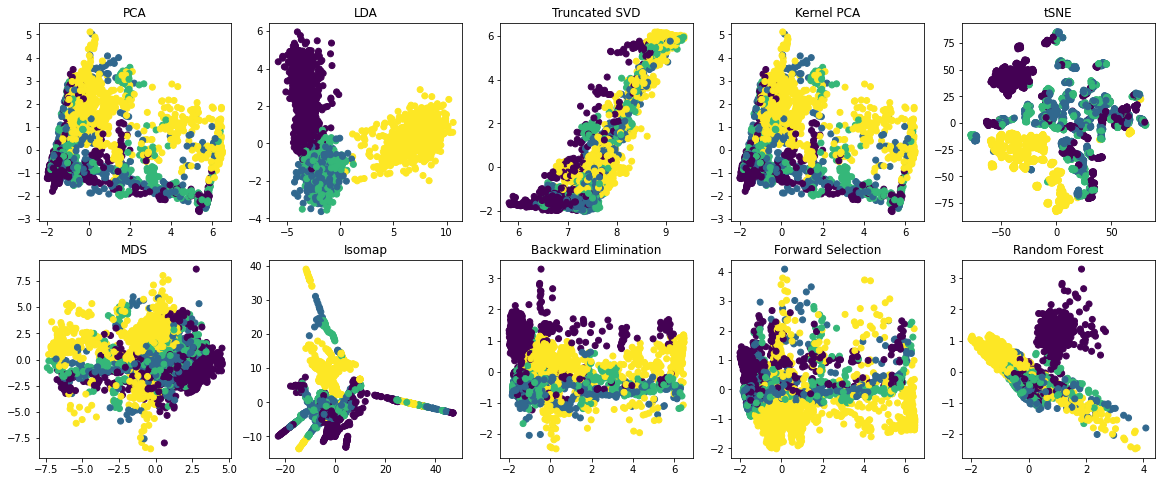

In [22]:
nrows, ncols = 2, 5

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20,8))

row = 0
col = 0
for key, item in dr_data_dict.items():
    ax[row, col].scatter(item[0][:, 0], item[0][:, 1], c=y_train)
    ax[row, col].set_title(key)
    col += 1
    if(col > 4):
        col = 0
        row = 1